# Compression of Images with CPD

In this notebook we will see how to compress a bitmap image using the CPD. Any image with colors can be seen as a $m \times n \times 3$ tensor, where each $m \times n$ slice corresponds to a specific color from the RGB encoding. More specifically, the first slice is the red slice, the seconds is green and the third is blue. Note we need to convert the tensor to uint8 format before and after the computations since this is the correct format for RGB images.

The general idea is the following: transform an image in a $m \times n \times 3$ tensor $T$, choose some rank $R$ and compute the low rank-$R$ approximation $T \approx (X, Y, Z) \cdot \mathcal{I}_{R \times R \times R}$ of this tensor. The original tensor has $3mn$ entries while the CPD has $R(m+n+3)$ entries. If $R < \frac{3mn}{m+n+3}$, then the compressed version of $T$ in fact need less memory to store information.   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import TensorFox as tfx

In [2]:
# Prepare data.

T_uint8= np.array(Image.open('input.bmp'))
T = np.array(T_uint8, dtype = np.float64)
m, n, p = T.shape
Tsize = np.linalg.norm(T)
print(T.shape)

(2844, 2216, 3)


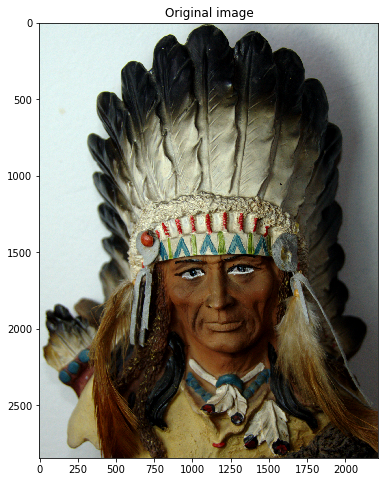

---------------------------------------------------------------
Accuracy of compressed version is of 90.85 %.
Compression version is 74.69 times smaller than original.


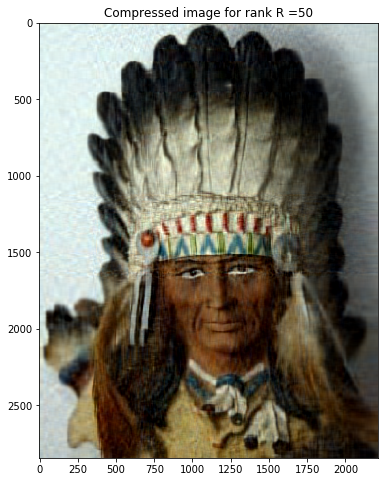

---------------------------------------------------------------
Accuracy of compressed version is of 93.81 %.
Compression version is 37.34 times smaller than original.


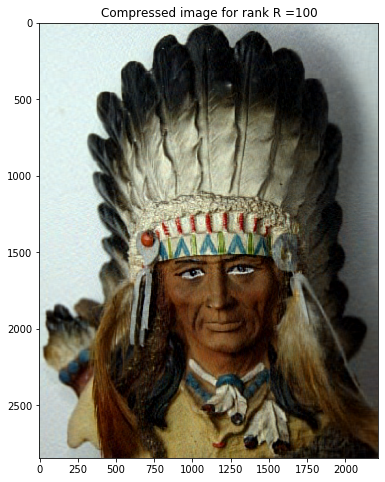

---------------------------------------------------------------
Accuracy of compressed version is of 95.08 %.
Compression version is 24.9 times smaller than original.


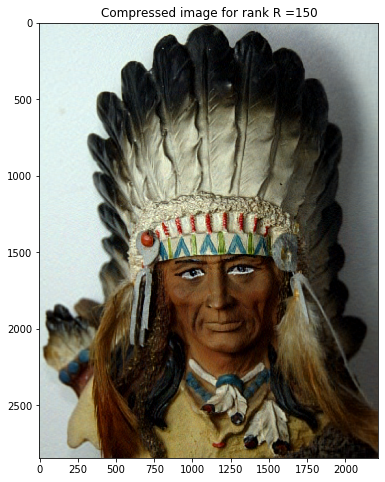

---------------------------------------------------------------
Accuracy of compressed version is of 95.87 %.
Compression version is 18.67 times smaller than original.


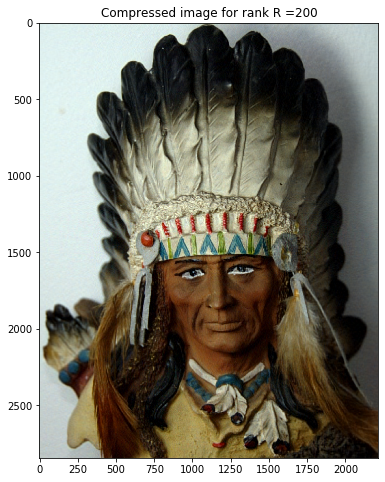

---------------------------------------------------------------
Accuracy of compressed version is of 96.41 %.
Compression version is 14.94 times smaller than original.


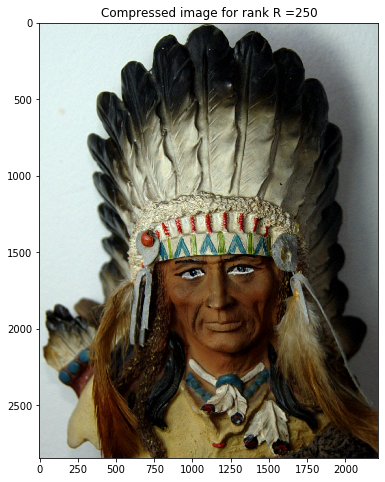

---------------------------------------------------------------
Accuracy of compressed version is of 96.69 %.
Compression version is 12.45 times smaller than original.


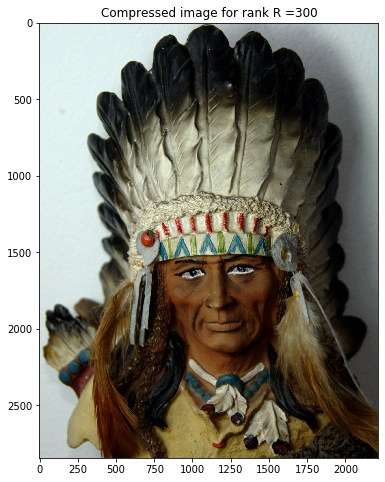

---------------------------------------------------------------
Accuracy of compressed version is of 96.78 %.
Compression version is 10.67 times smaller than original.


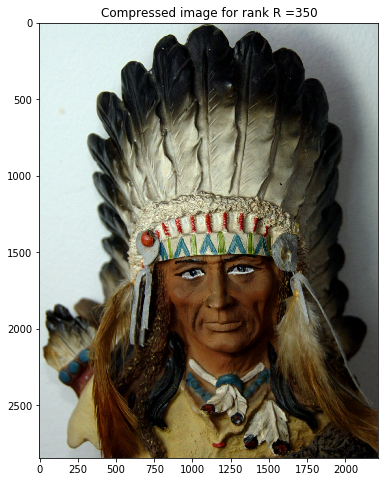

In [3]:
# Plot original image.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.imshow(T_uint8)
plt.title('Original image')
plt.show()

# Initialize arrays with the quality of compression (accuracy) and level of compression (how many times
# the compressed tensor is smaller than the original tensor).
compression_quality = []
compression_level = []

for R in [50, 100, 150, 200, 250, 300, 350]:
    factors, output = tfx.cpd(T, R)
    compression_quality.append(output.accuracy)
    compression_level.append(m*n*p/(R*(m+n+p)))
    
    print('---------------------------------------------------------------')
    print('Accuracy of compressed version is of', np.round(output.accuracy, 2),'%.')
    print('Compression version is', np.round(m*n*p/(R*(m+n+p)), 2), 'times smaller than original.' )
    
    # Plot compressed image.
    T_approx = tfx.cnv.cpd2tens(factors)
    T_approx = tfx.disp.adjust(T_approx, m, n, p)
    T_approx_uint8 = np.array(T_approx, dtype = np.uint8)
    plt.imshow(T_approx_uint8)
    plt.title('Compressed image for rank R =' + str(R))
    plt.show()

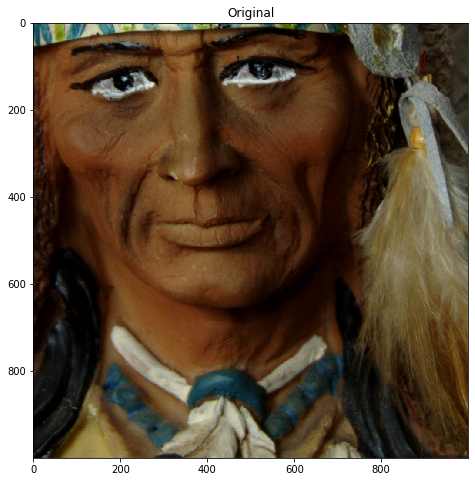

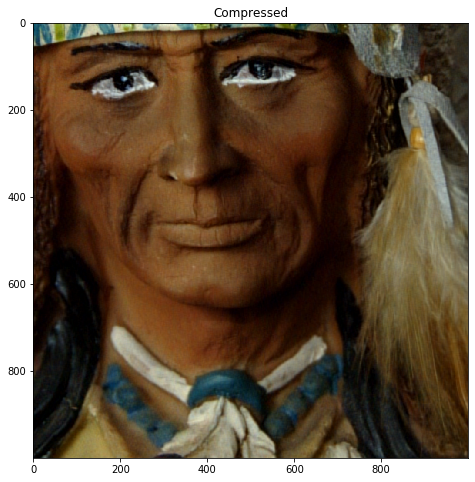

In [4]:
# Zoom in the last compression (rank = 350) and compare it to the original in more detail. 
# It is possible to see that still there are imperfections, which is to be expected in any compression.

plt.imshow(T_uint8[1500:2500, 800:1800])
plt.title('Original')
plt.show()

plt.imshow(T_approx_uint8[1500:2500, 800:1800])
plt.title('Compressed')
plt.show()

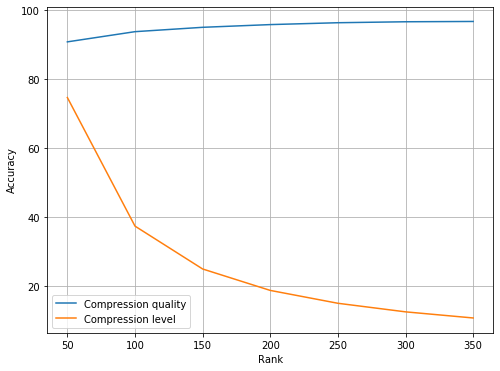

In [5]:
# Show the evolution of quality and compression level.

fig_size[0] = 8
fig_size[1] = 6
plt.plot([50, 100, 150, 200, 250, 300, 350], compression_quality, label = 'Compression quality')
plt.plot([50, 100, 150, 200, 250, 300, 350], compression_level, label = 'Compression level')
plt.xlabel('Rank')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

We choose $R = 150$ because this is the first rank with accuracy larger than $95 \%$, which we considered to be an acceptable accuracy threshold in this example. Furthermore, after $R = 150$ the quality of the compression doesn't improve too much, whereas the level of reduction decreases rapidly. In order to have the bigger reduction with the best quality, we choose $R = 150$ as the best rank. Below we repeat the CPD computation for $R = 150$, and after that we save the final image.

Note that, although the compressed version is $24.9$ times smaller than the original (see below), this is with respect to the tensor representation, not the saved file. In fact, the original file (*input.bmp*) has $25.2$ MB, while the compressed image (*output.png*) has $5.6$ MB, which is $4.5$ times smaller than the original file.

In [6]:
R = 150

start = time.time()
factors, output = tfx.cpd(T, R)
end = time.time()

print('Computational time necessary to make the compression = ', np.round(end - start, 2), 'seconds')
print('Accuracy of compressed version is of', np.round(output.accuracy, 2),'%.')
print('Compression version is', np.round(m*n*p/(R*(m+n+p)), 2), 'times smaller than original.' )

# The CPD of a RGB image will have approximated values (float), not integers in the range [0, 255]. 
# The function adjust fix this issue. The output is still a float array, but with rounded values.
T_approx = tfx.cnv.cpd2tens(factors)
T_approx = tfx.disp.adjust(T_approx, m, n, p)
T_approx_uint8 = np.array(T_approx, dtype = np.uint8)

# Save last compressed image.
img = Image.fromarray(T_approx_uint8) 
img.save("output_cpd.png")

Computational time necessary to make the compression =  28.06 seconds
Accuracy of compressed version is of 95.2 %.
Compression version is 24.9 times smaller than original.


# Final Remarks

This work showed how to use the CPD to compress images. The techniques used here are very general and can be applied not only to image compression but to any kind of data which can be converted to a 3D array. 

Just as the SVD is not the best method to compress gray scale images, the CPD is not the best method to compress RGB images. The objective of this work is to illustrate how the CPD can be used in real world applications. The advantage of the CPD is the possibility of generalization. Just as the SVD, compression of images is just one particular application. There are several other applications where the SVD (or the CPD) is the best choice.   